In [1]:
import pandas as pd

In [4]:
# Load the datasets
anime_df = pd.read_csv(r"C:\Users\shashi\Downloads\anime.csv")
rating_df = pd.read_csv(r"C:\Users\shashi\Downloads\anime_rating.csv")

In [6]:
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [8]:
rating_df.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [12]:
# Check for missing values
print("\nMissing values in anime data:")
print(anime_df.isnull().sum())


Missing values in anime data:
anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64


In [14]:
print("\nMissing values in rating data:")
print(rating_df.isnull().sum())


Missing values in rating data:
user_id     0
anime_id    0
rating      0
dtype: int64


In [16]:
# Drop rows with missing values in the anime dataset
anime_df = anime_df.dropna()

In [18]:
# Filter out users and anime with too few interactions
min_user_ratings = 50
min_anime_ratings = 50

user_counts = rating_df["user_id"].value_counts()
anime_counts = rating_df["anime_id"].value_counts()

rating_df = rating_df[rating_df["user_id"].isin(user_counts[user_counts >= min_user_ratings].index)]
rating_df = rating_df[rating_df["anime_id"].isin(anime_counts[anime_counts >= min_anime_ratings].index)]

print(f"Filtered rating data shape: {rating_df.shape}")

Filtered rating data shape: (898259, 3)


In [20]:
# Merge anime and rating data
merged_df = pd.merge(rating_df, anime_df, on="anime_id")

In [22]:
# Display the merged dataset
print(merged_df.head())

   user_id  anime_id  rating_x                       name  \
0        1        20        -1                     Naruto   
1        1        24        -1              School Rumble   
2        1        79        -1                   Shuffle!   
3        1       226        -1                 Elfen Lied   
4        1       241        -1  Girls Bravo: First Season   

                                               genre type episodes  rating_y  \
0  Action, Comedy, Martial Arts, Shounen, Super P...   TV      220      7.81   
1                   Comedy, Romance, School, Shounen   TV       26      8.06   
2  Comedy, Drama, Ecchi, Fantasy, Harem, Magic, R...   TV       24      7.31   
3  Action, Drama, Horror, Psychological, Romance,...   TV       13      7.85   
4     Comedy, Ecchi, Fantasy, Harem, Romance, School   TV       11      6.69   

   members  
0   683297  
1   178553  
2   158772  
3   623511  
4    84395  


In [24]:
from surprise.model_selection import train_test_split
from surprise import Dataset, Reader

In [26]:
# Define the rating scale
reader = Reader(rating_scale=(1, 10))

In [28]:
# Load the dataset into Surprise
data = Dataset.load_from_df(rating_df[["user_id", "anime_id", "rating"]], reader)

In [30]:
# Split the dataset into training and testing sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

In [32]:
from surprise import SVD
from surprise import accuracy

In [34]:
# Initialize the SVD model
model = SVD(n_factors=50, n_epochs=20, lr_all=0.005, reg_all=0.02)

In [36]:
# Train the model on the training set
model.fit(trainset)

In [38]:
# Make predictions on the test set
predictions = model.test(testset)

In [40]:
# Evaluate the model
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)
print(f"RMSE: {rmse}, MAE: {mae}")

RMSE: 2.2097
MAE:  1.5344
RMSE: 2.2097174756319307, MAE: 1.5343790205478307


In [42]:
#Generate Recommendations

In [46]:
def get_top_n_recommendations(user_id, model, n=10):
    # Get a list of all anime IDs
    anime_ids = rating_df["anime_id"].unique()

    # Predict ratings for all anime
    user_predictions = [model.predict(user_id, anime_id) for anime_id in anime_ids]

    # Sort predictions by estimated rating
    top_n = sorted(user_predictions, key=lambda x: x.est, reverse=True)[:n]

    # Return the top-N recommendations
    return top_n

In [48]:
# Example: Get top 10 recommendations for user_id = 1
user_id = 1
top_n = get_top_n_recommendations(user_id, model, n=10)

# Display the recommendations
for i, pred in enumerate(top_n):
    anime_info = anime_df[anime_df["anime_id"] == pred.iid].iloc[0]
    print(f"{i+1}. Anime: {anime_info['name']}, Genre: {anime_info['genre']}, Predicted Rating: {pred.est:.2f}")

1. Anime: High School DxD, Genre: Comedy, Demons, Ecchi, Harem, Romance, School, Predicted Rating: 6.01
2. Anime: High School DxD New, Genre: Action, Comedy, Demons, Ecchi, Harem, Romance, School, Predicted Rating: 5.75
3. Anime: Sword Art Online, Genre: Action, Adventure, Fantasy, Game, Romance, Predicted Rating: 5.04
4. Anime: Highschool of the Dead, Genre: Action, Ecchi, Horror, Supernatural, Predicted Rating: 4.11
5. Anime: Kino no Tabi: The Beautiful World - Tou no Kuni, Genre: Adventure, Fantasy, Psychological, Predicted Rating: 3.05
6. Anime: Koe de Oshigoto! The Animation, Genre: Comedy, Ecchi, Seinen, Predicted Rating: 2.90
7. Anime: Evangelion: 3.0 You Can (Not) Redo, Genre: Action, Mecha, Sci-Fi, Predicted Rating: 2.88
8. Anime: Fullmetal Alchemist: Premium Collection, Genre: Comedy, Fantasy, Shounen, Predicted Rating: 2.61
9. Anime: Baby Steps 2nd Season, Genre: Romance, School, Shounen, Sports, Predicted Rating: 2.54
10. Anime: Summer Wars, Genre: Comedy, Sci-Fi, Predicted

In [50]:
import matplotlib.pyplot as plt

In [52]:
# Extract anime names and predicted ratings
anime_names = [anime_df[anime_df["anime_id"] == pred.iid].iloc[0]["name"] for pred in top_n]
pred_ratings = [pred.est for pred in top_n]

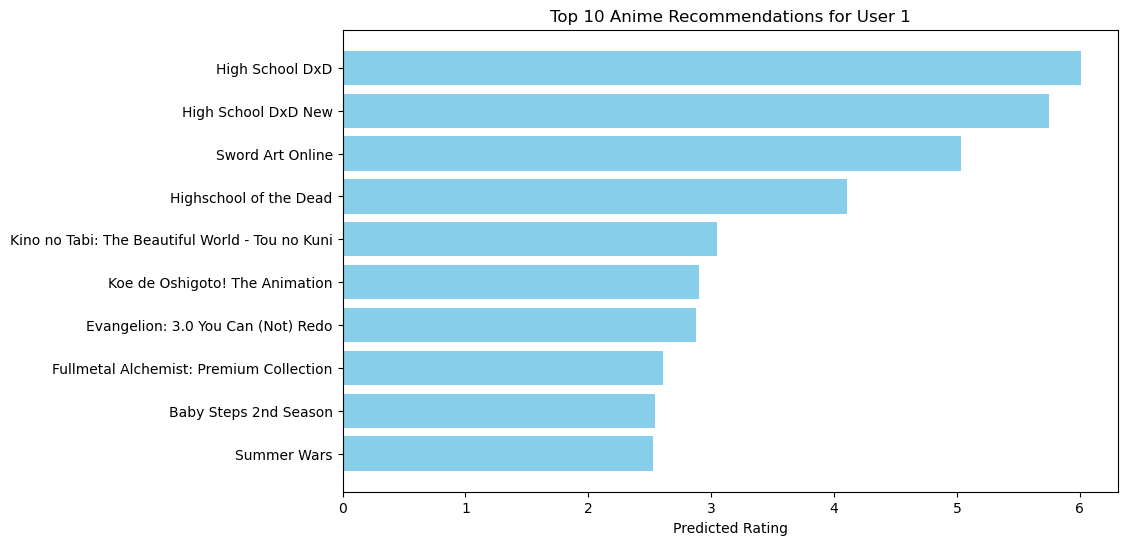

In [54]:
# Plot the recommendations
plt.figure(figsize=(10, 6))
plt.barh(anime_names, pred_ratings, color="skyblue")
plt.xlabel("Predicted Rating")
plt.title(f"Top 10 Anime Recommendations for User {user_id}")
plt.gca().invert_yaxis()  # Invert y-axis to show the highest rating at the top
plt.show()

In [92]:
# Example: Get top 10 recommendations for user_id = 5
user_id = 5
top_n = get_top_n_recommendations(user_id, model, n=10)

# Display the recommendations
for i, pred in enumerate(top_n):
    anime_info = anime_df[anime_df["anime_id"] == pred.iid].iloc[0]
    print(f"{i+1}. Anime: {anime_info['name']}, Genre: {anime_info['genre']}, Predicted Rating: {pred.est:.2f}")

1. Anime: Gintama&#039;, Genre: Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen, Predicted Rating: 10.00
2. Anime: Kimi no Na wa., Genre: Drama, Romance, School, Supernatural, Predicted Rating: 10.00
3. Anime: Kara no Kyoukai 7: Satsujin Kousatsu (Kou), Genre: Action, Mystery, Romance, Supernatural, Thriller, Predicted Rating: 9.54
4. Anime: Barakamon, Genre: Comedy, Slice of Life, Predicted Rating: 9.51
5. Anime: Sennen Joyuu, Genre: Action, Adventure, Drama, Fantasy, Historical, Romance, Predicted Rating: 9.32
6. Anime: Hunter x Hunter (2011), Genre: Action, Adventure, Shounen, Super Power, Predicted Rating: 9.21
7. Anime: Ghost in the Shell: Stand Alone Complex 2nd GIG, Genre: Action, Mecha, Military, Mystery, Police, Sci-Fi, Seinen, Predicted Rating: 9.14
8. Anime: Kara no Kyoukai 5: Mujun Rasen, Genre: Action, Drama, Mystery, Romance, Supernatural, Thriller, Predicted Rating: 8.95
9. Anime: Gintama°, Genre: Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen,

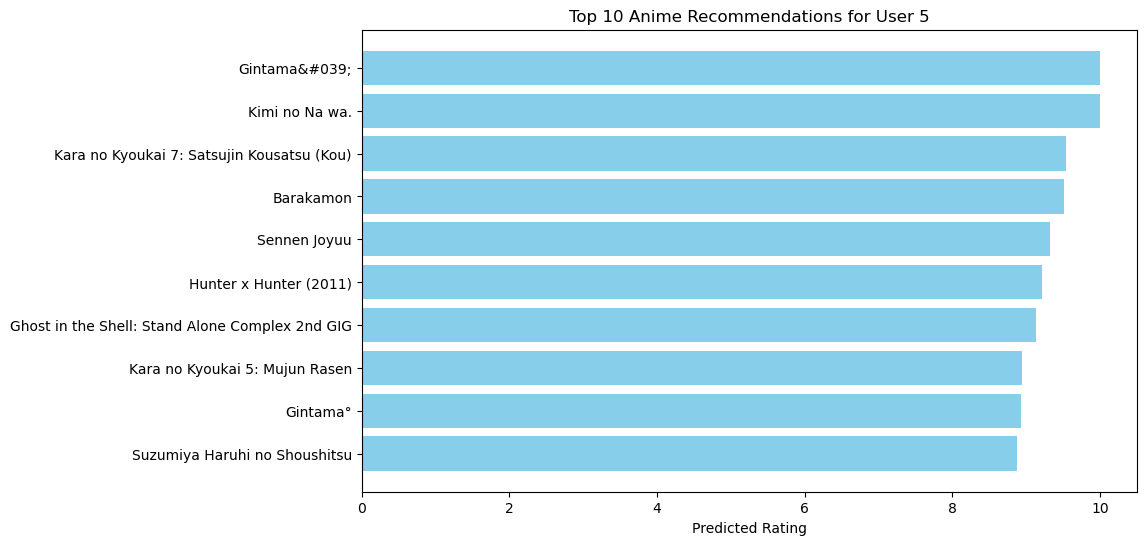

In [94]:
anime_names = [anime_df[anime_df["anime_id"] == pred.iid].iloc[0]["name"] for pred in top_n]
pred_ratings = [pred.est for pred in top_n]
# Plot the recommendations
plt.figure(figsize=(10, 6))
plt.barh(anime_names, pred_ratings, color="skyblue")
plt.xlabel("Predicted Rating")
plt.title(f"Top 10 Anime Recommendations for User {user_id}")
plt.gca().invert_yaxis()  # Invert y-axis to show the highest rating at the top
plt.show()

In [96]:
import joblib

# Save the model
joblib.dump(model, "anime_recommendation_model.pkl")

['anime_recommendation_model.pkl']